In [1]:
import pandas as pd
import biom
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline

In [2]:
from ch.ch_plots import plot_indiv_hulls_by_group
from ch.ch_plots import plot_group_hulls_over_time
from ch.ch_plots import plot_3d_hulls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load a table and associated metadata

- If you have already calculated an ordination as an `skbio.OrdinationResults` object, you can skip the ordination calculation step.

- If your metadata is comma separated, adjust the call to `pd.read_csv`

- This tutorial uses the Xue J, Allaband C, Zhou D, et al. 2021 dataset published here: [[link](https://pubmed.ncbi.nlm.nih.gov/33897472/)]

In [5]:
tab = biom.load_table('data/table.biom')
metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata.head()

,sample_name,metab-sample-id,age_units,anonymized_name,cage_food_consumption_g,cage_location,cage_notes,cage_number,collection_timestamp,description,...,physical_specimen_location,qiita_study_id,sample_type,scientific_name,sex,taxon_id,title,weight_units,age_bin,age_match
0,11829.A41.166.21,A41_166_21,weeks,A41.166.21,46.9,In chamber,NaN,A41,6/12/18 11:00,Mouse 166 stool collection 21 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,20.0,20.0
1,11829.A41.163.2,A41_163_2,weeks,A41.163.2,41.8,In chamber,NaN,A41,4/6/18 11:00,Mouse 163 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5
2,11829.A35.142.21,A35_142_21,weeks,A35.142.21,54.5,On shelf,NaN,A35,6/12/18 12:00,Mouse 142 stool collection 21 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,20.0,20.0
3,11829.A37.149.11,A37_149_11,weeks,A37.149.11,49.8,In chamber,NaN,A37,5/8/18 10:00,Mouse 149 stool collection 11 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,16.0,15.0
4,11829.A41.165.2,A41_165_2,weeks,A41.165.2,41.8,In chamber,NaN,A41,4/6/18 11:00,Mouse 165 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5


### Examine how many observations at each timepoint for each condition we have

- We are interested in how IH (intermittent hypoxia) or IC (hypercapnia) alter the microbiome. 

- Our time variable will be given by `age_match`

- Our group variable will be IH vs. IC vs. Air (control) which in the metadata is called `exposure_type`

- Our subject id variable is called `host_subject_id`

In [6]:
pd.DataFrame(metadata[['age_match', 'exposure_type']].value_counts()).sort_values(by='age_match')

count
age_match exposure_type       
10.0      IC                16
          Air               15
          IH                15
10.5      IC                16
          IH                16
          Air               15
15.0      IC                16
          IH                16
          Air               15
20.0      IC                16
          IH                16
          Air               13

### Define group, subject, and time columns of interest

In [7]:
groupc = 'exposure_type'
subjc = 'host_subject_id'
timec = 'age_match'

### Visualize each time point in 3d

- Use an appropriate distance metric to generate an ordination. You may use any distance metric / beta diversity metric you'd like. In this tutorial we will be using RPCA.

- If you are unfamiliar with this step please consult the RPCA tutorial on the gemelli github page [[link](https://github.com/biocore/gemelli/blob/master/gemelli/q2/plugin_setup.py)]

- The github page gives a more detailed explanation of how the RPCA distance metric works and how to use it.

- Your downstream results will be impacted based on which distance metric you choose to use.


In [8]:
# First we must generate an ordination
from gemelli.rpca import rpca
ordination, distance_mat = rpca(tab.copy())

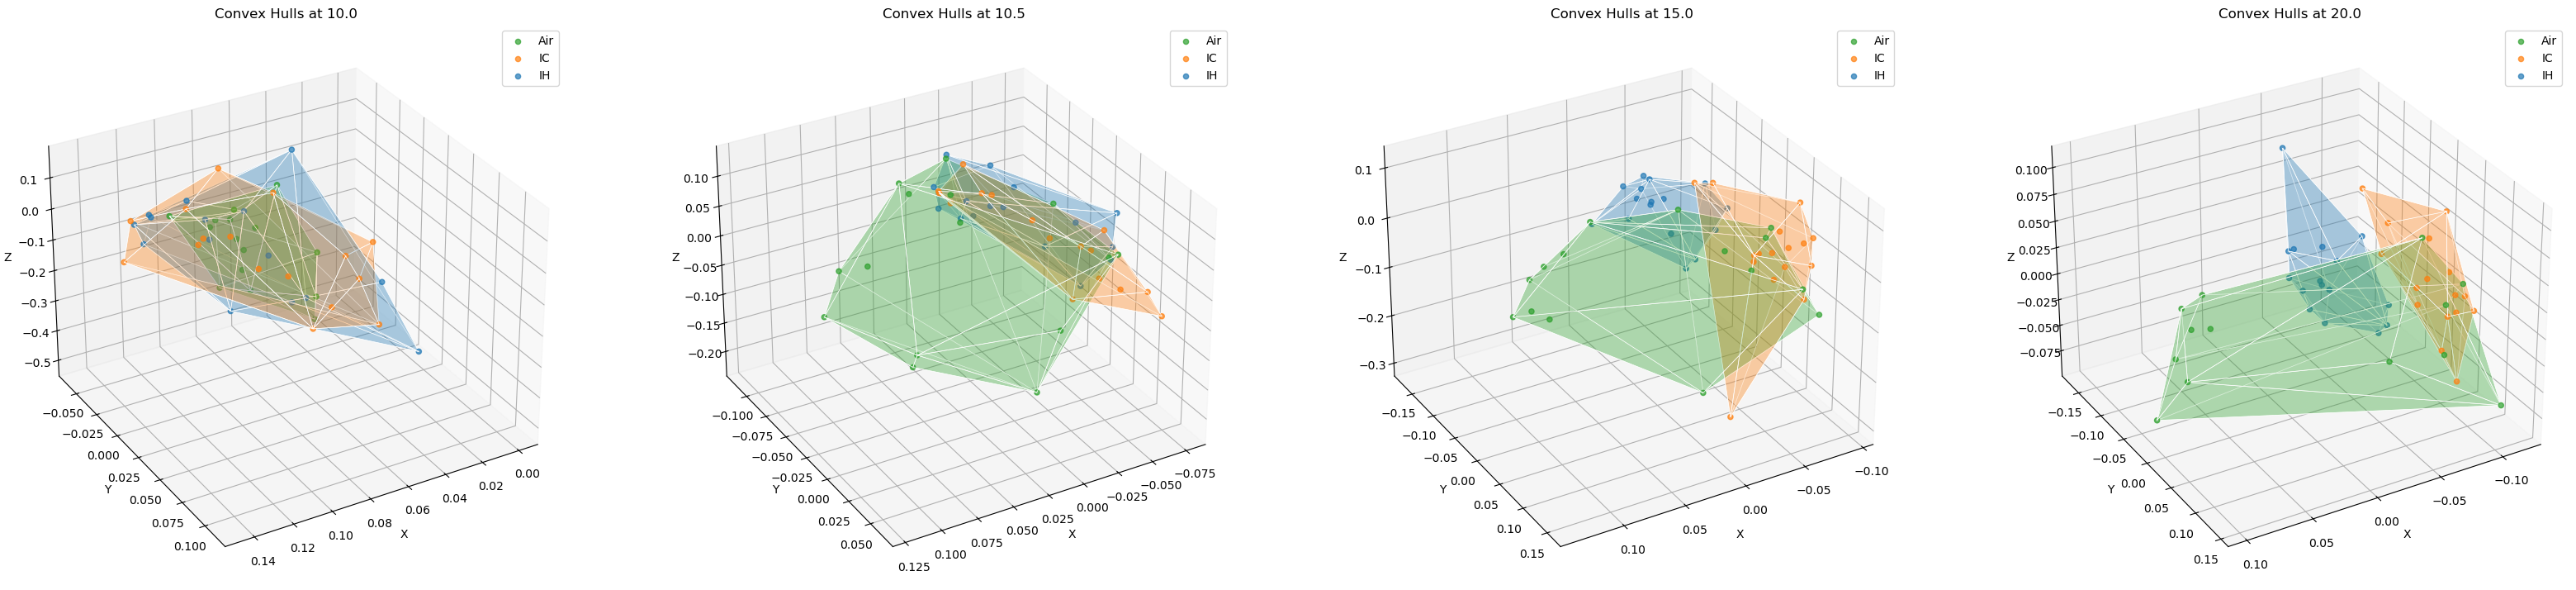

In [9]:
fig, hp = plot_3d_hulls(
    ordination=ordination,
    metadata=metadata,  
    groupc=groupc,
    subjc=subjc,
    timec=timec,
    axis=True,
    rotation=60)

In [10]:
fig.savefig('data/out-3d_hulls.svg', bbox_inches='tight')

### Generate Convex Hull calculations dataframe and subsample by time and group

These plots will calculate the volumes seen above. Visually you should be able to see a trend that resembles the fluctuation in 3d figure sizes. Distributions of points are generated by iterative subsampling. This is done to account for outliers that may be heavily skewing the hull volume.

We can also view the associated hull volumes calculated in a dataframe.

,age_match,exposure_type,convexhull_volume,convexhull_area,npoints,iteration,individual
0,10.0,Air,0.000239,0.025987,10,iter-0,not applicable
1,10.5,Air,0.001633,0.089530,10,iter-0,not applicable
2,15.0,Air,0.002095,0.103608,10,iter-0,not applicable
3,20.0,Air,0.001366,0.079318,10,iter-0,not applicable
4,10.0,IC,0.001357,0.099922,10,iter-0,not applicable


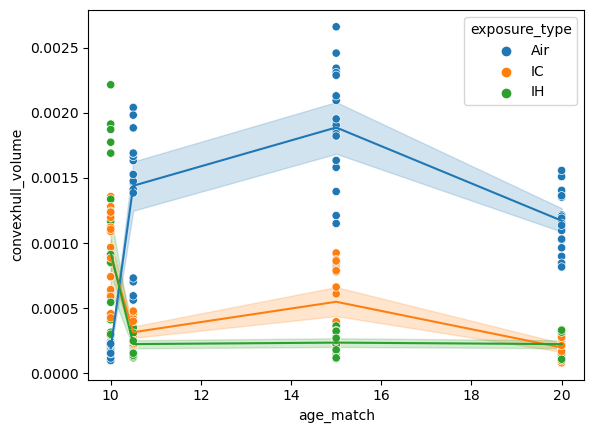

In [11]:
group_df, group_fig = plot_group_hulls_over_time(
    ordination, metadata,
    groupc, subjc, timec,
    n_subsamples=10, n_iters=20)

group_df.head()

In [12]:
# Optional - save
group_fig.savefig('data/out-group-hulls.svg', bbox_inches='tight')
group_df.to_csv('data/out-group-hulls.tsv', sep='\t', index=False)

### Box plot of convex hull volumes

These plots show the convex hull volume of individuals over time. In this case, the hulls are calculated over a single subject, not over multiple subjects in one goup.

We can view the hulls calculated over an individual over time as a data frame.

,age_match,exposure_type,convexhull_volume,convexhull_area,npoints,iteration,individual
0,None,Air,0.000018,0.009418,4,iter-0,Mouse 135
1,None,Air,0.000002,0.001555,4,iter-0,Mouse 136
2,None,Air,0.000029,0.012918,4,iter-0,Mouse 137
3,None,Air,0.000021,0.009047,4,iter-0,Mouse 138
4,None,Air,0.000011,0.005543,4,iter-0,Mouse 139


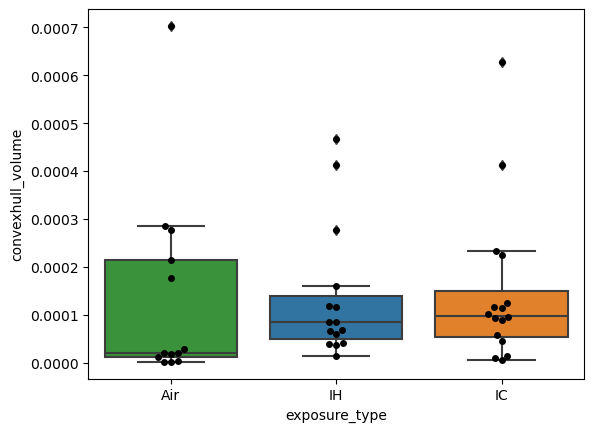

In [13]:
indiv_df, indiv_fig = plot_indiv_hulls_by_group(
    ordination, metadata,
    groupc, subjc, timec,
    n_subsamples=None)

indiv_df.head()

In [14]:
# Optional - save
indiv_fig.savefig('data/out-indiv-hulls.svg', bbox_inches='tight')
group_df.to_csv('data/out-indiv-hulls.tsv', sep='\t', index=False)